In [1]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim

In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, normalize=False, data_name='custom'):
        super().__init__()
        self.data_name = data_name
        self.normalize = normalize
        self.image_mask_pairs = []

        # 遍历所有文件夹，找到图像文件和相应的掩码文件
        for folder in sorted(Path(directory).iterdir()):
            if folder.is_dir():
                imgs = list(sorted(folder.glob('*.png'), key=lambda x: int(x.stem.split('_')[-1])))  
                mask_file = next(folder.glob('*.npy'), None) 
                
                if mask_file and len(imgs) > 0:
                    masks = np.load(mask_file)  
                    if len(imgs) == len(masks):
                        for img, mask in zip(imgs, masks):
                            self.image_mask_pairs.append((img, mask))
                    else:
                        print(f"Warning: Mismatched number of images and masks in {folder}")

        # 图像的预处理
        self.transform_image = transforms.Compose([
            transforms.ToTensor(),
            # 这里可以添加更多的转换，例如图像增强等
        ])

        # 控制是否进行归一化
        if normalize:
            self.transform_mask = transforms.Compose([
                transforms.ToTensor(),  # 这会转换为0-1范围的浮点数
                # 这里可以添加特定于掩码的其他预处理步骤
            ])
        else:
            # 如果不归一化，仅转换为Tensor
            self.transform_mask = lambda x: torch.from_numpy(x).long() 

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, index):
        image_file, mask_array = self.image_mask_pairs[index]
        image = self.transform_image(Image.open(image_file).convert('RGB')) 
        mask = self.transform_mask(mask_array)
        return image, mask

train_data = CustomDataset('/scratch/yg2709/CSCI-GA-2572-Deep-Learning-Final-Competition-Dragonfruit/dataset/train', normalize=False)
val_data = CustomDataset('/scratch/yg2709/CSCI-GA-2572-Deep-Learning-Final-Competition-Dragonfruit/dataset/val', normalize=False)

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = True)

In [8]:
from typing import Dict

 
# 在uent中卷积一般成对使用
class DoubleConv(nn.Sequential):
    # 输入通道数， 输出通道数， mid_channels为成对卷积中第一个卷积层的输出通道数
    def __init__(self, in_channels, out_channels, mid_channels=None):
        if mid_channels is None:
            mid_channels = out_channels
        super(DoubleConv, self).__init__(
            # 3*3卷积，填充为1，卷积之后输入输出的特征图大小一致
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
 
# 下采样
class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__(
            # 1.最大池化的窗口大小为2， 步长为2
            nn.MaxPool2d(2, stride=2),
            # 2.两个卷积
            DoubleConv(in_channels, out_channels)
        )
 
 
# 上采样
class Up(nn.Module):
    # bilinear是否采用双线性插值
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            # 使用双线性插值上采样
            # 上采样率为2，双线性插值模式
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # 使用转置卷积上采样
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
 
    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        # [N, C, H, W]
        # 上采样之后的特征图与要拼接的特征图，高度方向的差值
        diff_y = x2.size()[2] - x1.size()[2]
        # 上采样之后的特征图与要拼接的特征图，宽度方向的差值
        diff_x = x2.size()[3] - x1.size()[3]
 
        # padding_left, padding_right, padding_top, padding_bottom
        # 1.填充差值
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
 
        # 2.拼接
        x = torch.cat([x2, x1], dim=1)
        # 3.两个卷积
        x = self.conv(x)
        return x
 
# 最后的1*1输出卷积
class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )
 
 
# unet网络模型
class UNet(nn.Module):
    # 参数: 输入通道数， 分割任务个数， 是否使用双线插值， 网络中第一个卷积通道个数
    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 49,
                 bilinear: bool = True,
                 base_c: int = 64):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear
 
        self.in_conv = DoubleConv(in_channels, base_c)
        # 下采样，参数:输入通道,输出通道
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        # 如果采用双线插值上采样为 2，采用转置矩阵上采样为 1
        factor = 2 if bilinear else 1
        # 最后一个下采样，如果是双线插值则输出通道为512，否则为1024
        self.down4 = Down(base_c * 8, base_c * 16 // factor)
        # 上采样，参数:输入通道,输出通道
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        # 最后的1*1输出卷积
        self.out_conv = OutConv(base_c, num_classes)
 
    # 正向传播过程
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        # 1. 定义最开始的两个卷积层
        x1 = self.in_conv(x)
        # 2. contracting path（收缩路径）
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # 3. expanding path（扩展路径）
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # 4. 最后1*1输出卷积
        logits = self.out_conv(x)
        return logits

100%|██████████| 688/688 [04:59<00:00,  2.30it/s]


Epoch [1/5], Train Loss: 0.3041


100%|██████████| 687/687 [02:04<00:00,  5.52it/s]


Epoch [1/5], Val Loss: 0.0569


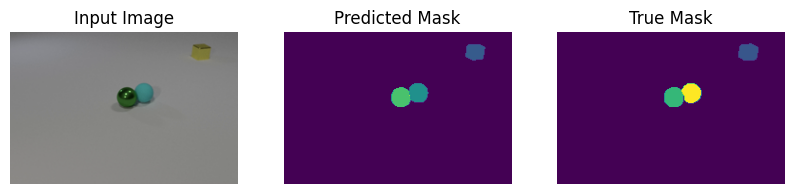

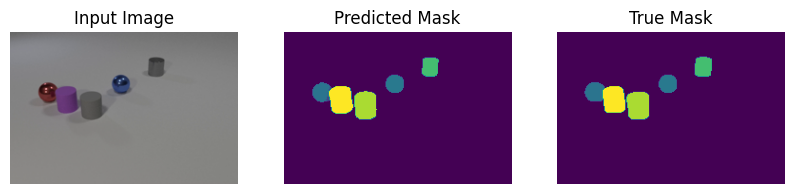

100%|██████████| 688/688 [04:52<00:00,  2.36it/s]


Epoch [2/5], Train Loss: 0.0133


100%|██████████| 687/687 [02:01<00:00,  5.63it/s]


Epoch [2/5], Val Loss: 0.0108


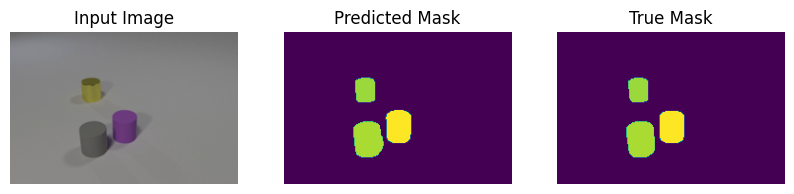

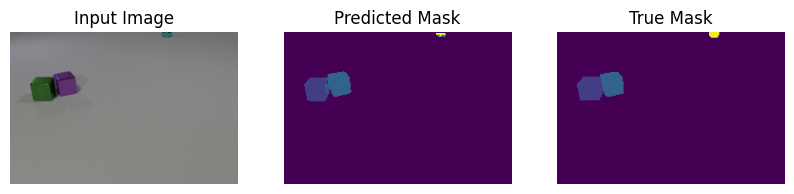

100%|██████████| 688/688 [04:52<00:00,  2.35it/s]


Epoch [3/5], Train Loss: 0.0078


 93%|█████████▎| 636/687 [01:53<00:09,  5.65it/s]

In [ ]:
model = UNet() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_images, val_masks in tqdm(val_loader):
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_masks).item()
            
            # 计算 IoU
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}')

    # with torch.no_grad():  # 关闭梯度计算
    #     for images, true_masks in train_loader:  # 加载一批图像和真实标签
    #         images = images.to(device)  # 确保数据在正确的设备上
    #         outputs = model(images)  # 获取模型输出
    #         predicted_masks = outputs.argmax(1)  # 获取预测的类别
    
    #         # 将预测掩码和真实掩码的数据类型转换为uint8
    #         predicted_masks = predicted_masks.byte().cpu().data
    #         true_masks = true_masks.byte().cpu().data
    
    #         # 将第一个图像转换为PIL图像以便可视化
    #         image = to_pil_image(images[0].cpu().data)
    #         predicted_mask = to_pil_image(predicted_masks[0])
    #         true_mask = to_pil_image(true_masks[0])
    
    #         # 绘制图像、预测和真实标签
    #         plt.figure(figsize=(10, 4))
    #         plt.subplot(1, 3, 1)
    #         plt.imshow(image)
    #         plt.title('Input Image')
    #         plt.axis('off')
            
    #         plt.subplot(1, 3, 2)
    #         plt.imshow(predicted_mask)
    #         plt.title('Predicted Mask')
    #         plt.axis('off')
            
    #         plt.subplot(1, 3, 3)
    #         plt.imshow(true_mask)
    #         plt.title('True Mask')
    #         plt.axis('off')
    
    #         plt.show()
    
    #         break  # 通常只查看一批中的第一个样本，所以在这里停止
    # with torch.no_grad():  # 关闭梯度计算
    #     for images, true_masks in val_loader:  # 加载一批图像和真实标签
    #         images = images.to(device)  # 确保数据在正确的设备上
    #         outputs = model(images)  # 获取模型输出
    #         predicted_masks = outputs.argmax(1)  # 获取预测的类别
    
    #         # 将预测掩码和真实掩码的数据类型转换为uint8
    #         predicted_masks = predicted_masks.byte().cpu().data
    #         true_masks = true_masks.byte().cpu().data
    
    #         # 将第一个图像转换为PIL图像以便可视化
    #         image = to_pil_image(images[0].cpu().data)
    #         predicted_mask = to_pil_image(predicted_masks[0])
    #         true_mask = to_pil_image(true_masks[0])
    
    #         # 绘制图像、预测和真实标签
    #         plt.figure(figsize=(10, 4))
    #         plt.subplot(1, 3, 1)
    #         plt.imshow(image)
    #         plt.title('Input Image')
    #         plt.axis('off')
            
    #         plt.subplot(1, 3, 2)
    #         plt.imshow(predicted_mask)
    #         plt.title('Predicted Mask')
    #         plt.axis('off')
            
    #         plt.subplot(1, 3, 3)
    #         plt.imshow(true_mask)
    #         plt.title('True Mask')
    #         plt.axis('off')
    
    #         plt.show()
    
    #         break  # 通常只查看一批中的第一个样本，所以在这里停止


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 假设 model 是你的训练好的模型，loader 是你的数据加载器
model.eval()  # 设置模型为评估模式

with torch.no_grad():  # 关闭梯度计算
    for images, true_masks in train_loader:  # 加载一批图像和真实标签
        images = images.to(device)  # 确保数据在正确的设备上
        outputs = model(images)  # 获取模型输出
        predicted_masks = outputs.argmax(1)  # 获取预测的类别

        # 将预测掩码和真实掩码的数据类型转换为uint8
        predicted_masks = predicted_masks.byte().cpu().data
        true_masks = true_masks.byte().cpu().data

        # 将第一个图像转换为PIL图像以便可视化
        image = to_pil_image(images[0].cpu().data)
        predicted_mask = to_pil_image(predicted_masks[0])
        true_mask = to_pil_image(true_masks[0])

        # 绘制图像、预测和真实标签
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask)
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask)
        plt.title('True Mask')
        plt.axis('off')

        plt.show()

        break  # 通常只查看一批中的第一个样本，所以在这里停止


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 假设 model 是你的训练好的模型，loader 是你的数据加载器
model.eval()  # 设置模型为评估模式

with torch.no_grad():  # 关闭梯度计算
    for images, true_masks in val_loader:  # 加载一批图像和真实标签
        images = images.to(device)  # 确保数据在正确的设备上
        outputs = model(images)  # 获取模型输出
        predicted_masks = outputs.argmax(1)  # 获取预测的类别

        # 将预测掩码和真实掩码的数据类型转换为uint8
        predicted_masks = predicted_masks.byte().cpu().data
        true_masks = true_masks.byte().cpu().data

        # 将第一个图像转换为PIL图像以便可视化
        image = to_pil_image(images[0].cpu().data)
        predicted_mask = to_pil_image(predicted_masks[0])
        true_mask = to_pil_image(true_masks[0])

        # 绘制图像、预测和真实标签
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask)
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask)
        plt.title('True Mask')
        plt.axis('off')

        plt.show()

        break  # 通常只查看一批中的第一个样本，所以在这里停止
